# Word2Vec (Skipgram)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
np.__version__, torch.__version__

('1.23.4', '1.13.1+cpu')

In [3]:
import matplotlib
matplotlib.__version__

'3.5.1'

## 1. Load data

In [4]:
#specify the sentences / corpus 
#corpus is define as set of document
#document is basically a nuch of sentence(s)
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple", 
          "dog cat animal", "cat dog animal", "cat animal dog"]

In [5]:
#1. tokenize
#usually you use spaCy/ NLTK to tokenize (but we gonna do this later on, we gonna have spaCy)
corpus_tokenized = [sent.split(" ") for sent in corpus]
corpus_tokenized #we called each of this as 'tokens' NOT words

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'dog', 'animal'],
 ['cat', 'animal', 'dog']]

In [6]:
#2. numericalize (vocab)

#2.1 get all the unique words
#we want to flatten unit (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus_tokenized))) #vocabs is a term degining all unique words your system know

In [7]:
#2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}
word2index

{'apple': 0, 'animal': 1, 'dog': 2, 'banana': 3, 'fruit': 4, 'cat': 5}

In [8]:
word2index['dog']

2

In [9]:
#add <UNK>, which is a very normal token exits in the world
vocabs.append('<UNK>') #chaky, can it be ##UNK, or UNKKKKK, or anything

In [10]:
#now we have a way to know what is the id of <UNK>
word2index['<UNK>'] = 6 #usually <UNK> is 0

In [11]:
#create index2word dictionary
# index2word = {idx: v for idx, v in enumerate(vocabs)}
# index2word

# for key,value in word2index.items():
#     print(key,value)

index2word = {v:k for k,v in word2index.items()}
index2word

{0: 'apple',
 1: 'animal',
 2: 'dog',
 3: 'banana',
 4: 'fruit',
 5: 'cat',
 6: '<UNK>'}

## 2. Prepare train data
You move the window along, and create those tuples as we said in class

In [12]:
#move along the corpus
#to fit with our corus, we gonna use window_size = 1
skipgrams =[]
#for each corpus
for sent in corpus_tokenized:
    #for each sent ('apple', 'banana', 'fruit')
    for i in range(1,len(sent)-1): #start from 1 to second last
        # print(sent[i])
        center_word = sent[i]
        outside_word = [sent[i-1],sent[i+1]] #window_size =1
        #here we want to create (banana, apple), (banana, fruit) append to some list
        for o in outside_word:
            skipgrams.append([center_word,o])
skipgrams

[['banana', 'apple'],
 ['banana', 'fruit'],
 ['apple', 'banana'],
 ['apple', 'fruit'],
 ['fruit', 'banana'],
 ['fruit', 'apple'],
 ['cat', 'dog'],
 ['cat', 'animal'],
 ['dog', 'cat'],
 ['dog', 'animal'],
 ['animal', 'cat'],
 ['animal', 'dog']]

In [13]:
# corpus = [  'apple banana fruit','banana apple fruit','banana fruit apple',
#             'dog cat animal', 'cat dog animal', 'cat animal dog']

In [14]:
#let's make what we have made into a fucntion (batch function)
#return a batches of data, e.g., = 2 --> ['banana', 'apple'],['banana','fruit']
#also i want these batches ti be id, NOT token --> [5,4]

def random_batch(batch_size, corpus):
    skipgrams =[]
    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ('apple', 'banana', 'fruit')
        for i in range(1,len(sent)-1): #start from 1 to second last
            # print(sent[i])
            center_word = word2index[sent[i]]
            outside_word = [word2index[sent[i-1]],word2index[sent[i+1]]] #window_size =1
            #here we want to create (banana, apple), (banana, fruit) append to some list
            for o in outside_word:
                skipgrams.append([center_word,o])
    #only get a batch, mot the entire lsit
    random_index = np.random.choice(range(len(skipgrams)),batch_size,replace=False)
    
    #appending some list of inputs and labels
    random_inputs, random_labels = [] , []
    for index in random_index:
        random_inputs.append([skipgrams[index][0]]) #center words, this will be as shape of (1,) -> (1,1) for modeling
        random_labels.append([skipgrams[index][1]])

    return np.array(random_inputs),np.array(random_labels)

In [15]:
input,label = random_batch(10, corpus_tokenized)

print(f'{input.shape}')
print(f'{label.shape=}')

(10, 1)
label.shape=(10, 1)


## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [16]:
voc_size = len(vocabs)
voc_size

7

In [17]:
vocabs

['apple', 'animal', 'dog', 'banana', 'fruit', 'cat', '<UNK>']

In [18]:
#the model will accept three vectors - u_o, v_c, u_w
#u_o - vectos for outside words
#v_C - vector for center word
#u_w - vectors of all vocabs

class Skipgram(nn.Module):
    def __init__(self,voc_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size) #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size,1)
        #all_vocabs : (batch_size, voc_size)

        #convert them into embedding
        center_word_embed = self.embedding_center_word(center_word)     #v_c (batch_size,1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)  #u_o (batch_size,1, emb_size)
        all_vocabs_embed = self.embedding_outside_word(all_vocabs)      #u_w (batch_size,voc_size, emb_size)
        
        #bmm is basically @ or .dot but across batches (ie., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size,1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term) #exp(uo vc)
        #(batch_size, 1)

        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) ===> (batch_size, voc_size)
        
        lower_term_sum = torch.sum(torch.exp(lower_term)) #sum exp(uw, vc)
        #(batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp/lower_term_sum))
        #(batc_size,1) / (batch_size,1) ==mena==> scalar

        return loss_fn

In [19]:
#preparing all_vocabs
batch_size = 2

def prepare_seqeunce(seq, word2index):
    #map(fucntion, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_seqeunce(list(vocabs),word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 7])

In [20]:
input, label = random_batch(1, corpus_tokenized)
input #center word

array([[2]])

In [21]:
label #context word

array([[5]])

In [22]:
emb_size = 2 #usually, this can be 50,100 or 300
model = Skipgram(voc_size,emb_size)

In [23]:
input_tensor = torch.LongTensor(input)
label_tensor  = torch.LongTensor(label) #longTensor menas integer......

In [24]:
#this is diffrence
torch.LongTensor(2)

tensor([28429333431058540,           7340141])

In [25]:
torch.LongTensor([2])

tensor([2])

In [26]:
input_tensor.shape, label_tensor.shape, all_vocabs.shape

(torch.Size([1, 1]), torch.Size([1, 1]), torch.Size([2, 7]))

In [28]:
#this should give one number
# loss = model(input_tensor,label_tensor, all_vocabs)
# loss

## 4. Training

In [31]:
batch_size = 2 #why? no reason
emb_size = 2 #why? no reason; usually 50,100, 300 but 2 so we can plot (50 can also plot, but need PCA)
model = Skipgram(voc_size,emb_size)

criterion = nn.CrossEntropyLoss() #-log
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
num_epochs = 5000
#for epoch
for epoch in range(num_epochs):
    #get random batch
    input_batch, label_batch = random_batch(batch_size,corpus)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)

    # print(input_batch.shape,label_batch.shape,all_vocabs.shape)
    
    #loss = model
    loss = model(input_batch,label_batch,all_vocabs)
    #backpropagate
    loss.backward()
    #update alpha
    optimizer.step()
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch {epoch+1} | Loss {loss:.6f} | Time : ?')

    # break

Epoch 1000 | Loss 2.130813 | Time : ?
Epoch 2000 | Loss 1.436613 | Time : ?
Epoch 3000 | Loss 1.398390 | Time : ?
Epoch 4000 | Loss 1.739642 | Time : ?
Epoch 5000 | Loss 1.502840 | Time : ?


In [33]:
print(input_batch.shape,label_batch.shape,all_vocabs.shape)

torch.Size([2, 1]) torch.Size([2, 1]) torch.Size([2, 7])


## 5. Plotting the embeddings

Is really the related studd are close to each other, and vice versa.

The most fun part: Will 'banana' closer to 'fruit' than 'cat'?

In [34]:
vocabs

['apple', 'animal', 'dog', 'banana', 'fruit', 'cat', '<UNK>']

In [35]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([3])

In [36]:
banana_center_embed = model.embedding_center_word(banana)
banana_outside_embed = model.embedding_outside_word(banana)
banana_embed = (banana_center_embed+banana_outside_embed)/2
banana_embed

tensor([[1.9162, 1.7556]], grad_fn=<DivBackward0>)

In [37]:
#find embedding of fruit, cat
def get_embed(word):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (model.embedding_center_word(word)+model.embedding_outside_word(word))/2
    return embed[0][0].item(),embed[0][1].item()
    
print(get_embed('fruit'))
print(get_embed('cat'))
print(get_embed('chaky'))

(1.0725374221801758, 2.2405805587768555)
(-2.4644765853881836, -0.9425819516181946)
(0.09451552480459213, -0.6877984404563904)


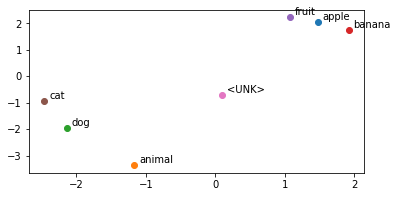

In [38]:
#help me plot fruit cat banana on maplotlib
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]):
    x,y = get_embed(word)
    plt.scatter(x,y)
    plt.annotate(word,xy=(x,y),xytext=(5,2),textcoords='offset points')
plt.show()

## 6. Cosine Similarity
How do (from Scratch) calcualte cosine similarity?

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [40]:
vocabs

['apple', 'animal', 'dog', 'banana', 'fruit', 'cat', '<UNK>']

In [41]:
#let's try similarity between first and second, and second and third
cat          = get_embed('cat')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [42]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"cat vs. fruit: ",cos_sim(cat, fruit))
print(f"cat vs. animal: ",cos_sim(cat, animal))
print(f"cat vs. cat: ",cos_sim(cat, cat))

cat vs. fruit:  -0.7254953248110259
cat vs. animal:  0.6442839064898912
cat vs. cat:  0.9999999999999999


In [43]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"cat vs. fruit: ",cos_sim(cat, fruit))
print(f"cat vs. animal: ",cos_sim(cat, animal))
print(f"cat vs. cat: ",cos_sim(cat, cat))

cat vs. fruit:  -0.7254953248110259
cat vs. animal:  0.6442839064898912
cat vs. cat:  1
